# memory usage

get the max memory usage found when running `fcdd/python/scripts/launch-check-memory.sh`

In [1]:
# setup

# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [2]:
%pwd
!ln -s /home/bertoldo/log/fcdd-memory-usage

'/home/bertoldo/repos/fcdd/python/analyse'

ln: failed to create symbolic link './fcdd-memory-usage': File exists


In [3]:
%ls fcdd-memory-usage/

cifar10.2022-01-26-18-05-18.gpu.log
cifar10.2022-01-26-18-05-18.mem.log
fmnist.2022-01-26-17-58-19.gpu.log
fmnist.2022-01-26-17-58-19.mem.log
mvtec-unsupervised.2022-01-26-18-16-50.gpu.log
mvtec-unsupervised.2022-01-26-18-16-50.mem.log
pascalvoc.2022-01-26-18-13-16.gpu.log
pascalvoc.2022-01-26-18-13-16.mem.log


In [17]:
LOGS_DIR = Path("fcdd-memory-usage")

logs = [
    "cifar10.2022-01-26-18-05-18.gpu.log",
    "cifar10.2022-01-26-18-05-18.mem.log",
    "fmnist.2022-01-26-17-58-19.gpu.log",
    "fmnist.2022-01-26-17-58-19.mem.log",
    # "mvtec-unsupervised.2022-01-26-18-16-50.gpu.log",
    # "mvtec-unsupervised.2022-01-26-18-16-50.mem.log",
    "pascalvoc.2022-01-26-18-13-16.gpu.log",
    "pascalvoc.2022-01-26-18-13-16.mem.log",
]

from pathlib import Path
from collections import defaultdict

logs = [LOGS_DIR / p for p in logs]

tmp = defaultdict(dict)

for log in logs:
    dataset, _, gpu_or_mem, _ = log.name.split(".")
    tmp[dataset][f"{gpu_or_mem}.fpath"] = log

logs = dict(tmp)
del tmp

In [18]:
p = logs["fmnist"]["mem.fpath"]
p
p.read_text().split("\n")[0]
p.read_text().split("\n")[1]
del p

PosixPath('fcdd-memory-usage/fmnist.2022-01-26-17-58-19.mem.log')

'  time :     cpu % -      vms(G)     rss(G)'

'     1 :  116.90 % -          7          0'

In [19]:
import numpy as np
from numpy import ndarray
from typing import Tuple


def get_mem(fpath: Path) -> Tuple[ndarray]:
    """
    :param fpath: points to a file ".mem.log", 
                  outputs of the script "pid-monitor.py" in my .dotfiles

    output memory values are in GB
    """
    values = [
        [
            # pid-monitor.py already gives values in GB
            float(s) 
            for s in l.split("-")[1].strip().split(" ")
            if s != ""
        ]
        for l in fpath.read_text().split("\n")[1:]  # skip header
        if l  # avoid empty lines
    ]

    values = np.array(values)
    vir, mem = values[:, 0], values[:, 1]
    return vir, mem
    

In [20]:
p = logs["fmnist"]["gpu.fpath"]
p
p.read_text().split("\n")[0]
del p

PosixPath('fcdd-memory-usage/fmnist.2022-01-26-17-58-19.gpu.log')

'cuda                 Wed Jan 26 17:58:19 2022  440.118.02'

In [21]:
def get_gpu(fpath: Path) -> Tuple[ndarray]:
    """
    :param fpath: points to a file ".gpu.log", 
                  outputs of the command "gpustat ... >> file.gpu.log"
                  
    output memory values are in GB
    """
    USER = "bertoldo"
    return np.array([
        # this incomprehenssible line is just successively splitting
        # the line and geting either the text to the left ([0]) or right ([-1])
        # and the "/1024" in the end is to convert the values to from MB to GB
        int(l.split("|")[-1].split(f"{USER}:python/")[-1].split("(")[-1].split("M)")[0]) / 1024
        for l in fpath.read_text().split("\n")
        if f"{USER}:python" in l
    ])

In [22]:
for log in logs.values():
    log["mem.vir"], log["mem.mem"] = get_mem(log["mem.fpath"])
    log["gpu"] = get_gpu(log["gpu.fpath"])    

In [26]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'cpu memory usage (GB)')

Text(0.5, 1.0, 'gpu memory usage (GB)')

Text(0.5, 0.98, "dataset='cifar10'")

Text(0.5, 1.0, 'cpu memory usage (GB)')

Text(0.5, 1.0, 'gpu memory usage (GB)')

Text(0.5, 0.98, "dataset='fmnist'")

Text(0.5, 1.0, 'cpu memory usage (GB)')

Text(0.5, 1.0, 'gpu memory usage (GB)')

Text(0.5, 0.98, "dataset='pascalvoc'")

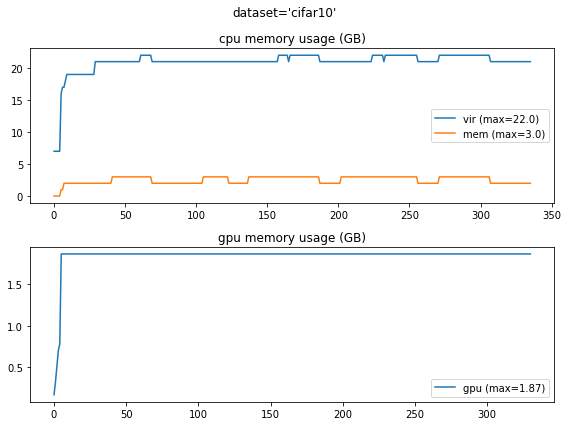

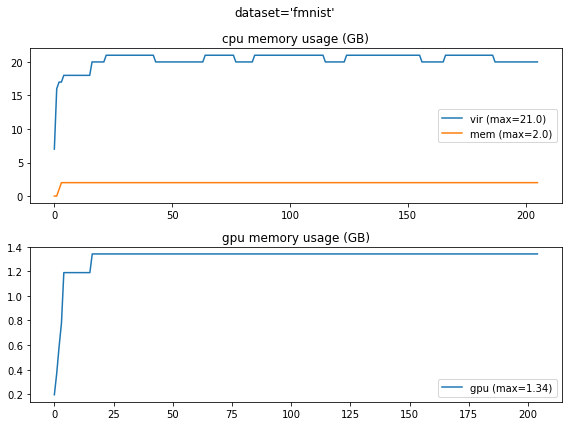

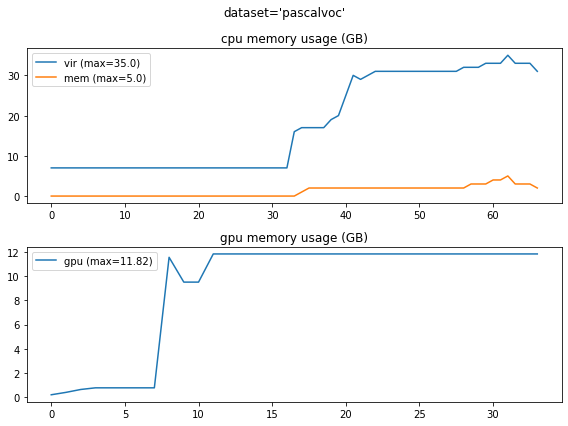

In [50]:

for dataset, data in logs.items():
    vir = data["mem.vir"]
    mem = data["mem.mem"]
    gpu = data["gpu"]
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    ax_mem, ax_gpu = axs
    
    ax_mem.plot(vir, label=f"vir (max={np.max(vir)})")
    ax_mem.plot(mem, label=f"mem (max={np.max(mem)})")
    ax_mem.legend()
    ax_mem.set_title("cpu memory usage (GB)")
    
    ax_gpu.plot(gpu, label=f"gpu (max={np.max(gpu):.2f})")
    ax_gpu.legend()
    ax_gpu.set_title("gpu memory usage (GB)")
    
    fig.suptitle(f"{dataset=}")
    fig.set_tight_layout(True)
